### Importing the necessary modules 

In [2]:
import os
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors, model_selection, metrics, preprocessing, base, datasets

### Collecting, Analyzing and Visualizing the data

In [32]:
path = os.path.abspath(os.path.join("Datasets", "50_Startups.csv"))

path = path.replace(os.path.join("Supervised", "Regression", "KNN_Regressor"), "")

In [33]:
# Loading a dataset into a dataframe

df = pd.read_csv(path)
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [16]:
df['State'].value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [18]:
df.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [23]:
# Correlation Matrix (Pearson Correlation Co-efficient)

corr_matrix = df.corr()
corr_matrix

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing Spend,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


In [21]:
df.corr()['Profit'].sort_values(ascending = False)

Profit             1.000000
R&D Spend          0.972900
Marketing Spend    0.747766
Administration     0.200717
Name: Profit, dtype: float64

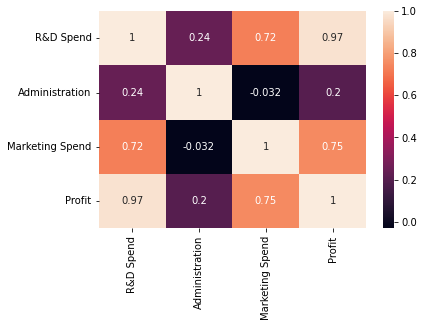

In [24]:
sns.heatmap(corr_matrix, annot = True)
plt.show()

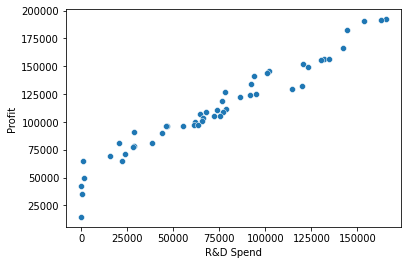

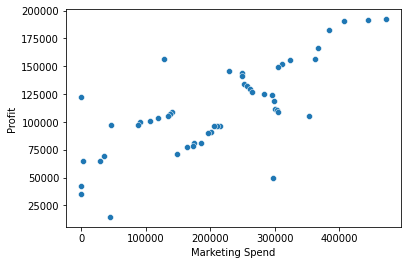

In [27]:
# Scatter Plot

sns.scatterplot(x = 'R&D Spend', y = 'Profit', data = df)
plt.show()

sns.scatterplot(x = 'Marketing Spend', y = 'Profit', data = df)
plt.show()

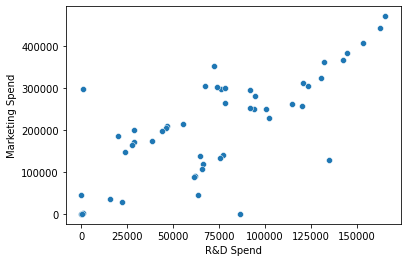

In [28]:
sns.scatterplot(x = 'R&D Spend', y = 'Marketing Spend', data = df)
plt.show()

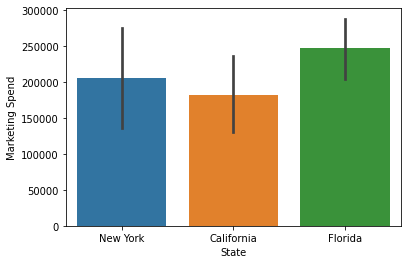

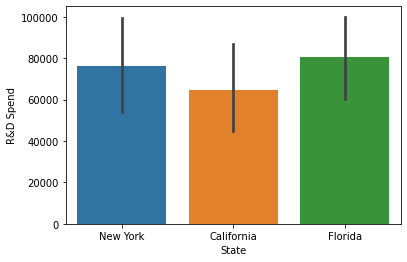

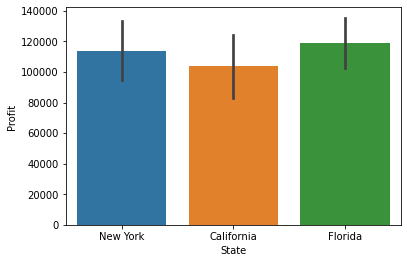

In [35]:
# Bar Chart

sns.barplot(x = 'State', y = 'Marketing Spend', data = df)
plt.show()

sns.barplot(x = 'State', y = 'R&D Spend', data = df)
plt.show()

sns.barplot(x = 'State', y = 'Profit', data = df)
plt.show()

In [44]:
# Mean Marketing Spend, R&D Spend and Profit corresponding to each state

ms_mean = df.groupby('State')['Marketing Spend'].mean()
rs_mean = df.groupby('State')['R&D Spend'].mean()
profit_mean = df.groupby("State")['Profit'].mean().sort_values(ascending = False)

print(ms_mean, '\n')
print(rs_mean, '\n')
print(profit_mean)

State
California    182540.929412
Florida       247323.551250
New York      205346.015882
Name: Marketing Spend, dtype: float64 

State
California    64657.674118
Florida       80724.016250
New York      76195.062353
Name: R&D Spend, dtype: float64 

State
Florida       118774.024375
New York      113756.446471
California    103905.175294
Name: Profit, dtype: float64


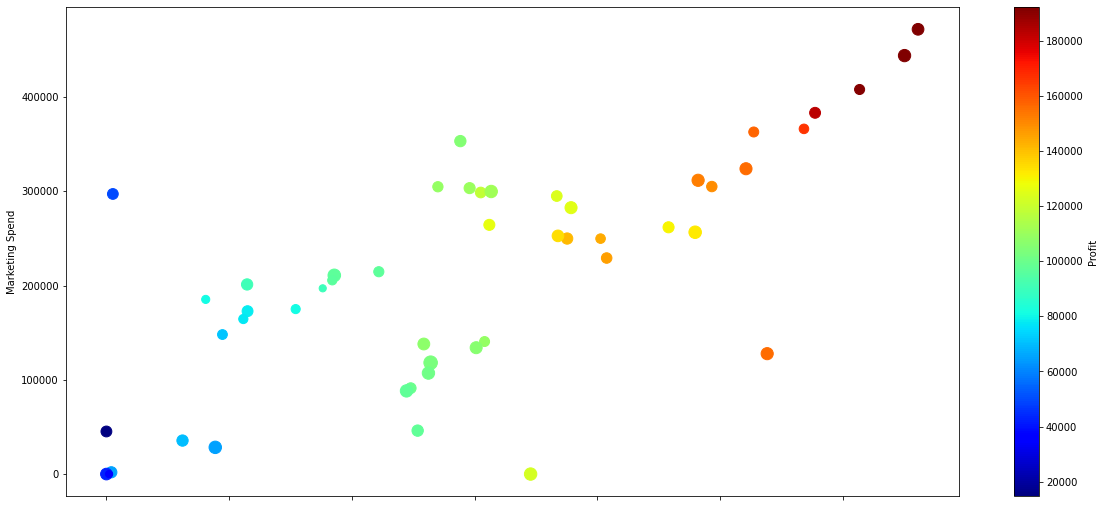

In [53]:
df.plot(kind = 'scatter', x = 'R&D Spend', y = 'Marketing Spend', c = 'Profit', s = df['Administration'] / 1000, cmap = plt.get_cmap('jet'), colorbar = True, figsize = (20, 9))
plt.show()

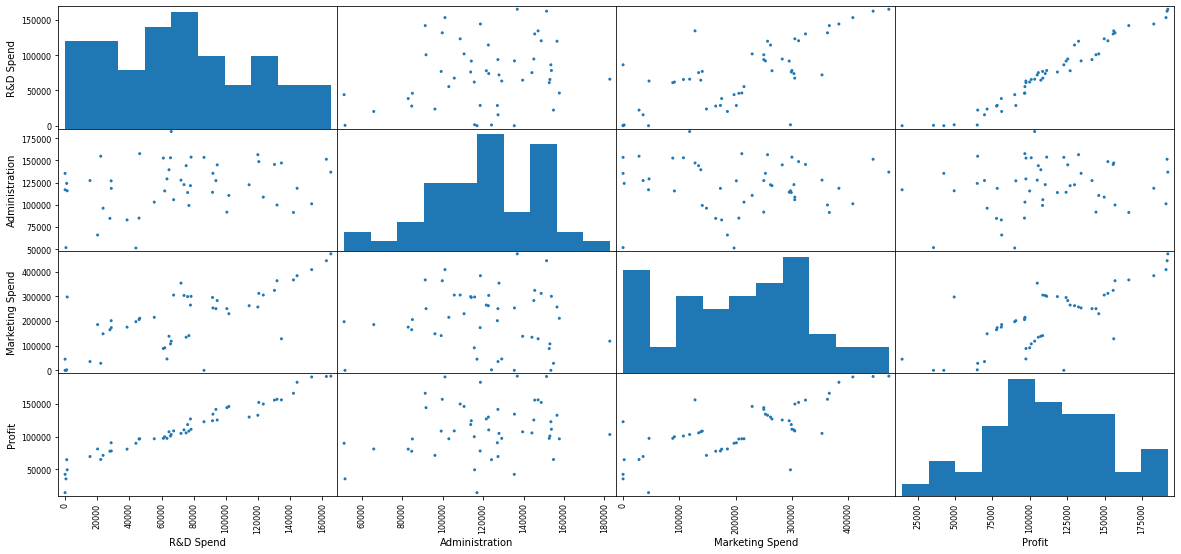

In [30]:
pd.plotting.scatter_matrix(df, figsize = (20, 9), alpha = 1)
plt.show()

### Data Preprocessing

In [60]:
# Encoding categorical data (One Hot Encoding)

states = pd.get_dummies(df['State']).drop('New York', axis = 1)

df = pd.concat([df, states], axis = 1).drop('State', axis = 1)
df.head()

,R&D Spend,Administration,Marketing Spend,Profit,California,Florida
0,165349.20,136897.80,471784.10,192261.83,0,0
1,162597.70,151377.59,443898.53,191792.06,1,0
2,153441.51,101145.55,407934.54,191050.39,0,1
3,144372.41,118671.85,383199.62,182901.99,0,0
4,142107.34,91391.77,366168.42,166187.94,0,1


### Preparing the Data

In [83]:
X = df.drop('Profit', axis = 1).values
y = df['Profit'].values

print(X.shape, y.shape)

(50, 5) (50,)


In [185]:
# Scaling the features (Min Max Scaling {0, 1})

def feature_scaler(X):
    X_scaled = X.copy()
    n_features = X_scaled.shape[1]
    for i in range(n_features):
        temp = X_scaled[:, i]
        X_scaled[:, i] = (temp - min(temp)) / (max(temp) - min(temp))
    return X_scaled

X = feature_scaler(X)
y = feature_scaler(y.reshape(-1, 1))[:, 0]
print(np.min(X), np.max(X))
print(np.min(y), np.max(y))

0.0 1.0
0.0 1.0


In [209]:
# Splitting the data into training and testing data

def split_data(X, y, split_ratio = 0.2, random_state = None):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    test_size = int(split_ratio * n_samples)
    random_indices = np.random.choice(np.arange(n_samples), size = n_samples, replace = False)
    train_indices = random_indices[test_size:]
    test_indices = random_indices[:test_size]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = split_data(X, y, split_ratio = 0.25, random_state = 3)
print(X_train.shape, X_test.shape)

(38, 5) (12, 5)


### Training the model and Evaluating it's performance

In [1]:
# Implementing KNN Regressor from scratch (Distance Metric : Euclidean Distance)

class KNNRegressor:
    
    def __init__(self, k = 3):
        self.X_train = self.y_train = None
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X):
        i, y_pred = 0, np.zeros(X.shape[0])
        for x1 in X:
            distances = [self.dist(x1, x2) for x2 in self.X_train]
            k_nearest_indices = np.argsort(distances)[:self.k]
            k_nearest_points = self.y_train[k_nearest_indices]
            y_pred[i] = np.mean(k_nearest_points)
            i += 1
        return y_pred
        
    @staticmethod
    def dist(x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

In [255]:
# Training the Regressor

reg = KNNRegressor(k = 1)

reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)

In [256]:
# Testing the model on training set

r2_score = metrics.r2_score(y_train, y_train_pred)
print("R Squared Value (Training Set) : ", r2_score)

R Squared Value (Training Set) :  1.0


### Validating the model 

In [257]:
# Testing the model on testing set

y_test_pred = reg.predict(X_test)

r2_score = metrics.r2_score(y_test, y_test_pred)
print("R Squared Value (Testing Set) : ", r2_score)

R Squared Value (Testing Set) :  0.6740540608269164


##  Sklearn Implementation

### Training the model and Evaluating it's performance

In [233]:
model = neighbors.KNeighborsRegressor(n_neighbors = 1)

model.fit(X_train, y_train)

print("R Squared Value (Training Set) : ", model.score(X_train, y_train))

R Squared Value (Training Set) :  1.0


### Validating the model

In [234]:
print("R Squared Value (Testing Set) : ", model.score(X_test, y_test))

R Squared Value (Testing Set) :  0.6740540608269164
